In [648]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [649]:
%autoreload
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
import fiona
import rasterio
import rasterio.mask
import rasterio.merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.fill import fillnodata
from rasterio.plot import show
import nexus_tool.weap_tools as wp
import os
import matplotlib.pyplot as plt
from shutil import copyfile
from datetime import date

## Reading files

In [650]:
provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg', encoding='utf-8')
groundwater = gpd.read_file('Data - Souss-Massa/Schematic/Groundwater.kml', encoding='utf-8')
wwtp = gpd.read_file('Data - Souss-Massa/Schematic/Wastewater Treatment Plants.kml', encoding='utf-8')
other_supply = gpd.read_file('Data - Souss-Massa/Schematic/Other Supplies.kml', encoding='utf-8')
river_withdrawals = gpd.read_file('Data - Souss-Massa/Schematic/River Withdrawals.kml', encoding='utf-8')
demand_sites = gpd.read_file('Data - Souss-Massa/Schematic/Demand Sites.kml', encoding='utf-8')
catchments = gpd.read_file('Data - Souss-Massa/Schematic/Catchments.kml', encoding='utf-8')
diversion = gpd.read_file('Data - Souss-Massa/Schematic/Diversions.kml', encoding='utf-8')
reservoirs = gpd.read_file('Data - Souss-Massa/Schematic/Reservoirs.kml', encoding='utf-8')
links = gpd.read_file('Data - Souss-Massa/Schematic/Transmission Links.kml', encoding='utf-8')

## Converting geometries and dropping unecesary columns

In [651]:
for gdf in [groundwater, wwtp, other_supply, river_withdrawals,
            demand_sites, catchments, diversion, reservoirs, links]:
    gdf['geometry'] = wp.polyz_to_poly(gdf)
    gdf.drop(columns='Description', inplace=True)

In [652]:
for gdf in [groundwater, wwtp, other_supply, river_withdrawals,
            reservoirs, demand_sites, catchments]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

links.rename(columns={'Name': 'links'}, inplace=True)
diversion.rename(columns={'Name': 'diversion'}, inplace=True)

## Defining types

In [653]:
groundwater['type'] = 'Groundwater supply'
wwtp['type'] = 'WWTP'
other_supply['type'] = 'Other supply'
river_withdrawals['type'] = 'Surfacewater withdrawal'
reservoirs['type'] = 'Reservoir supply'
catchments['type'] = 'Catchment'
demand_sites['type'] = 'Demand site'
diversion['type'] = 'Transmission Pipeline'
links['type'] = 'Transmission links'

In [654]:
# other_supply['point'] = 'Prelevement 3'
supply_points = groundwater.append([other_supply, reservoirs, river_withdrawals], ignore_index=True, sort=False)
demand_points = demand_sites.append(catchments, ignore_index=True, sort=False)
links['links'] = links.links.str.replace('Groundwater','GW')
links['links'] = links.links.str.replace('Grounwater','GW')
links['links'] = links.links.str.replace('GW of ','')
links['links'] = links.links.str.replace('GW ','')
links['links'] = links.links.str.strip()
links['links'] = links.links.str.replace(' El Guerdane',' I_El Guerdane')

In [655]:
demand_links = gpd.sjoin(demand_points, links, how='inner', op='intersects')
supply_links = gpd.sjoin(supply_points, links, how='inner', op='intersects')


In [656]:
demand_links.rename(columns={'type_left': 'type'}, inplace=True)
demand_links.drop(columns=['type_right', 'index_right'], inplace=True)
supply_links.rename(columns={'type_left': 'type'}, inplace=True)
supply_links.drop(columns=['type_right', 'index_right'], inplace=True)

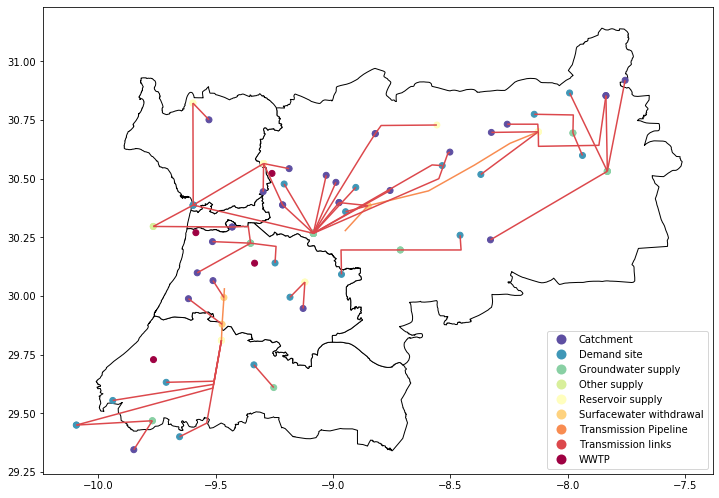

In [657]:
base = provinces.plot(color='white', edgecolor='black', figsize=(12, 12))
data = demand_links.append([supply_links, wwtp, diversion, links], ignore_index=True, sort=False)
data.plot(ax=base, column='type', cmap='Spectral_r', legend=True)
plt.show()

In [658]:
out_image, out_meta = wp.mask_raster('Data - Souss-Massa/GIS/wtd/Africa_model_wtd_v2.nc', 
                                  'Data - Souss-Massa/GIS/Admin/Provinces.gpkg', 'EPSG:4326')
       
with rasterio.open("Data - Souss-Massa/GIS/wtd//Souss-Massa WTD.tif", "w", **out_meta) as dest:
    dest.write(out_image)

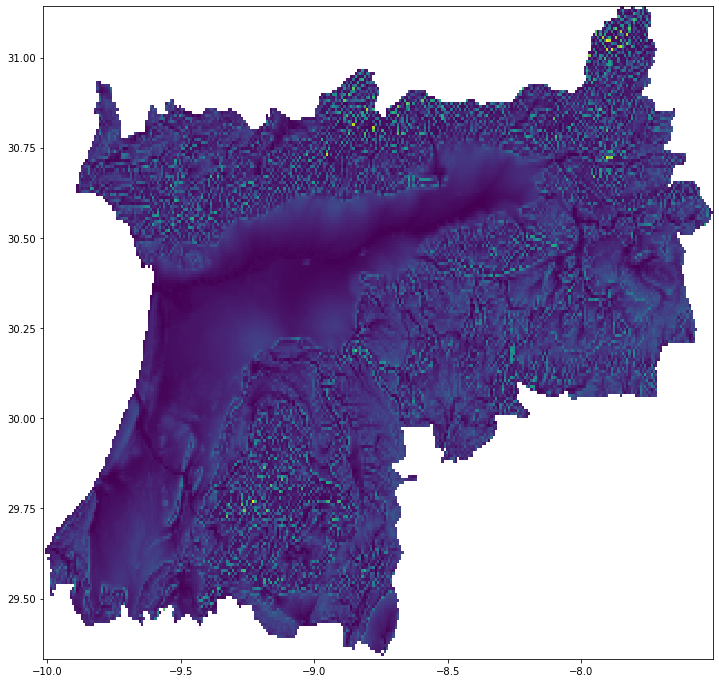

In [659]:
with rasterio.open("Data - Souss-Massa/GIS/wtd//Souss-Massa WTD.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, aspect='auto')

In [660]:
groundwater['wtd_m'] = wp.sample_raster("Data - Souss-Massa/GIS/wtd/Africa_model_wtd_v2.nc", 
                                         groundwater)

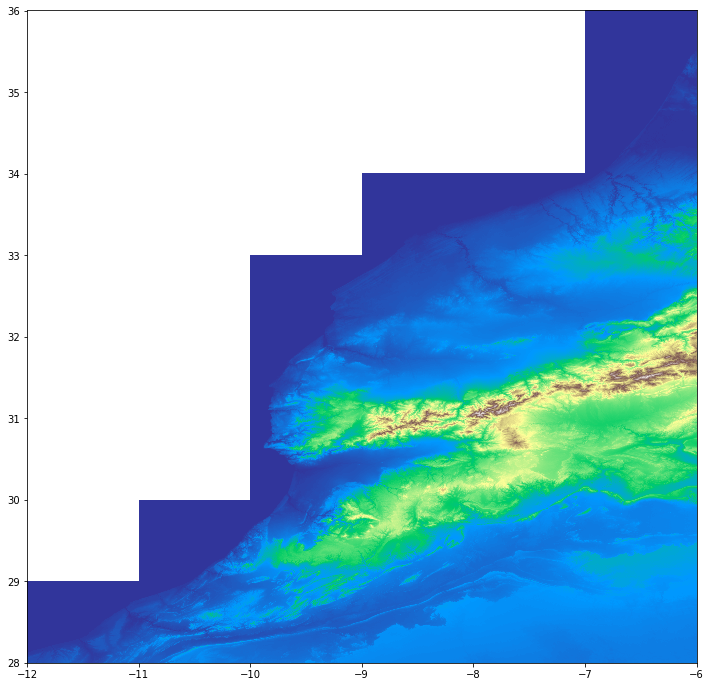

In [661]:
wp.merge_rasters('Data - Souss-Massa/GIS/DEM/*', 'EPSG:4326', 
                 "Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif")

with rasterio.open("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, aspect='auto', cmap='terrain')

In [662]:
supply_links['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                               supply_links)
demand_links['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                               demand_links)
wwtp['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                       wwtp)

In [663]:
diversions = gpd.sjoin(diversion, reservoirs, how='inner', op='intersects')
diversions.drop(columns=['index_right'], inplace=True)
diversions.rename(columns={'type_right': 'type_supply'}, inplace=True)
diversions = gpd.sjoin(diversions, river_withdrawals, how='inner', op='intersects')
diversions.drop(columns=['index_right'], inplace=True)
diversions.rename(columns={'point_left': 'Supply point', 'point_right': 'Demand point',
                           'type_left': 'type', 'type': 'type_demand'}, inplace=True)

In [664]:
dff1 = river_withdrawals.loc[river_withdrawals.point.isin(diversions['Demand point'])].copy()
dff1['diversion'] = dff1.point.map(diversions.set_index('Demand point').diversion)
dff1['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                       dff1)

In [665]:
dff2 = reservoirs.loc[reservoirs.point.isin(diversions['Supply point'])].copy()
dff2['diversion'] = dff2.point.map(diversions.groupby('Supply point').agg({'diversion': 'first'})['diversion'])
dff2['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                       dff2)
dff2.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)

In [666]:
dff1.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
dff1.set_index('diversion', inplace=True)
dff1['distance'] = dff1.distance(dff2.set_index('diversion')).copy()

In [667]:
diversions['distance'] = diversions['Demand point'].map(dff1.set_index('point')['distance'])
diversions['elevation_diff'] = diversions['Demand point'].map(dff1.set_index('point')['elevation_m']) - \
                               diversions['Supply point'].map(dff2.set_index('point')['elevation_m'])
diversions

,diversion,geometry,type,Supply point,type_supply,Demand point,type_demand,distance,elevation_diff
0,ConduiteEl Guerdane,"LINESTRING (-8.12489 30.69973, -8.24548 30.650...",Transmission Pipeline,Complexe Aoulouz Mokhtar Soussi,Reservoir supply,Withdrawal Node 1,Surfacewater withdrawal,77847.692844,-466.0
1,Youssef ben Tachfine Canal,"LINESTRING (-9.47543 29.81078, -9.47261 29.879...",Transmission Pipeline,Youssef Ben Tachefine,Reservoir supply,Withdrawal Node 3,Surfacewater withdrawal,7614.098123,69.0
1,Youssef ben Tachfine Canal,"LINESTRING (-9.47543 29.81078, -9.47261 29.879...",Transmission Pipeline,Youssef Ben Tachefine,Reservoir supply,Withdrawal Node 2,Surfacewater withdrawal,20253.108322,60.0


In [668]:
all_points = supply_links.append(demand_links, sort=False, ignore_index=True)
all_points.drop_duplicates(subset="point", inplace=True)

In [669]:
files_dict = {'Reference': {'Eto trend': ['Souss-Massa_Reference.xlsx']}}

raw_data = os.path.join('Data - Souss-Massa', 'WEAP Results')
results_path = os.path.join('Data - Souss-Massa', 'Processed Results')
wp.create_folder(results_path)
for scenario, files in files_dict.items():
    scenario_path = os.path.join(results_path, scenario)
    wp.create_folder(scenario_path)
    for folder, file in files.items():
        folder_path = os.path.join(scenario_path, folder)
        wp.create_folder(folder_path)
        for i, f in enumerate(file):
            dst = os.path.join(folder_path, f'level_{i+1}')
            wp.create_folder(dst)
            copyfile(os.path.join(raw_data, f), os.path.join(dst, 'results.xlsx'))

In [670]:
def integrate_data(sheet_name, category, dff_dict, var_name='links', target='point'):
    df = data.parse(sheet_name, skiprows=3)
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df.columns = df.columns.str.replace('"', '').str.strip()

    df.columns = df.columns.str.replace('Groundwater','GW')
    df.columns = df.columns.str.replace('Grounwater','GW')
    df.columns = df.columns.str.replace('GW of ','')
    df.columns = df.columns.str.replace('GW ','')

    for link in demand_links.links:
        if np.array(df.columns[df.columns.str.contains(link)]).size > 0:
            df.rename(columns={df.columns[df.columns.str.contains(link)][0]: link}, inplace=True)

    df = df.loc[df.Date!='Sum']
    df.Date = pd.to_datetime(df.Date)
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    
    drop_columns = []
    if 'Sum' in df.columns:
        drop_columns.append('Sum')
    df.drop(columns=drop_columns, inplace=True)

    df = df.melt(id_vars=['Date', 'Year', 'Month'])
    
    for name, dff in dff_dict.items():
        df_temp = dff.set_index(var_name)
        if var_name!=target:
            df[name] = df.variable.map(df_temp[target])
    
    df['type'] = category
    df.rename(columns={'variable': var_name}, inplace=True)
    print(df.loc[~df[var_name].isin(df.dropna()[var_name].unique()),var_name].unique())
    return df

In [671]:
scenarios = ['Reference']
processed_data = os.path.join('Data - Souss-Massa', 'Merged data')
wp.create_folder(processed_data)
for scenario in scenarios:
    scenario_folder = os.path.join(results_path, scenario)
    wp.create_folder(os.path.join(processed_data, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        wp.create_folder(os.path.join(processed_data, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(processed_data, scenario, sub_scenario, level)
            wp.create_folder(output_folder)
            file = os.path.join(sub_scenario_folder, level, 'results.xlsx')
            data = pd.ExcelFile(file)
            
            sheet_names = {'Desalination': 'Desalination plant', 
                           'GP Irrigation': 'GW Agriculture', 
                           'GP Domestic': 'GW Domestic',
                           'MAR': 'Aquifer recharge',
                           'SW Irrigation': 'SW Agriculture',
                           'SW Domestic': 'SW Domestic'}
            
            df = pd.DataFrame()
            for sheet_name, category in sheet_names.items():
                df = df.append(integrate_data(sheet_name, category, {'Demand point': demand_links, 
                                                                     'Supply point': supply_links}))
            
            df['wtd'] = df['Supply point'].map(groundwater.set_index('point')['wtd_m'])
            
            wtd_change = integrate_data('GW Change in Elev', 'GW wtd', {'GW': groundwater}, 'point', 'point')
            df.set_index(['Date', 'Supply point'], inplace=True)
            df['wtd'] -= df.index.map(wtd_change.set_index(['Date', 'point']).value)
            df.reset_index(inplace=True)
            
            df['elevation_diff'] = df.links.map(demand_links.set_index('links').elevation_m) - \
                                   df.links.map(supply_links.set_index('links').elevation_m)
            
            dff = df.loc[df['Supply point'].isin(diversions['Demand point'].unique())].groupby(['Date','Supply point','Year','Month']).agg({'value': 'sum'}).reset_index()
            dff.rename(columns={'Supply point': 'Demand point'}, inplace=True)
            dff['Supply point'] = dff['Demand point'].map(diversions.set_index('Demand point')['Supply point'])
            dff['elevation_diff'] = dff['Demand point'].map(diversions.set_index('Demand point')['elevation_diff'])
            dff['type'] = 'Transmission Pipeline'
            
            df = df.append(dff, sort=False, ignore_index=True)
            
            supply = gpd.GeoDataFrame(geometry=df['Supply point'].map(all_points.set_index('point').geometry), crs='epsg:4326')
            supply.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
            demand = gpd.GeoDataFrame(geometry=df['Demand point'].map(all_points.set_index('point').geometry), crs='epsg:4326')
            demand.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
            df['distance'] = supply.distance(demand)
            
            df_wwtp = integrate_data('WWTP Inflow', 'wwtp', {'WWTP': wwtp}, 'point', 'point')
            
            df.to_csv(os.path.join(output_folder, 'demand_data.csv'), index=False)
            df_wwtp.to_csv(os.path.join(output_folder, 'wwtp_inflow.csv'), index=False)
            
            
            

[]
[]
[]
[]
[]
[]
[]
[]


In [672]:
demand_links.loc[~demand_links['links'].isin(df['links'].unique()), 'links'].unique()

array(['Transmission Link from Souss to Ouled Teima',
       'Transmission Link from Tiznit to Sidi Ifni',
       'Transmission Link from Withdrawal Node 2 to I_Modern Public Massa',
       'Transmission Link from Withdrawal Node 3 to I_Tassila'],
      dtype=object)

In [673]:
folder = r'Morocco dashboard/spatial_data'
wp.create_folder(folder)
demand_links.to_file(os.path.join(folder, 'Demand_points.geojson'), driver='GeoJSON')
supply_links.to_file(os.path.join(folder, 'Supply_points.geojson'), driver='GeoJSON')
wwtp.to_file(os.path.join(folder, 'wwtp.geojson'), driver='GeoJSON')
diversions.to_file(os.path.join(folder, 'Pipelines.geojson'), driver='GeoJSON')

In [129]:
df = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\cropland_2013_processed_20200218_clean.csv", encoding='utf-8')
df.drop(columns=['WKT', 'gen2013', 'area_m2'], inplace=True)
df.rename(columns={'area_ha': 'area_m2'}, inplace=True)
df.columns=df.columns.str.replace('mea','')

In [130]:
for column in list(df)[0:-2]:
    df[column] = df[column].astype('float')

In [131]:
MerchidSudMoroc = 26192
for gdf in [provinces]:
    gdf.to_crs(epsg=MerchidSudMoroc, inplace=True)

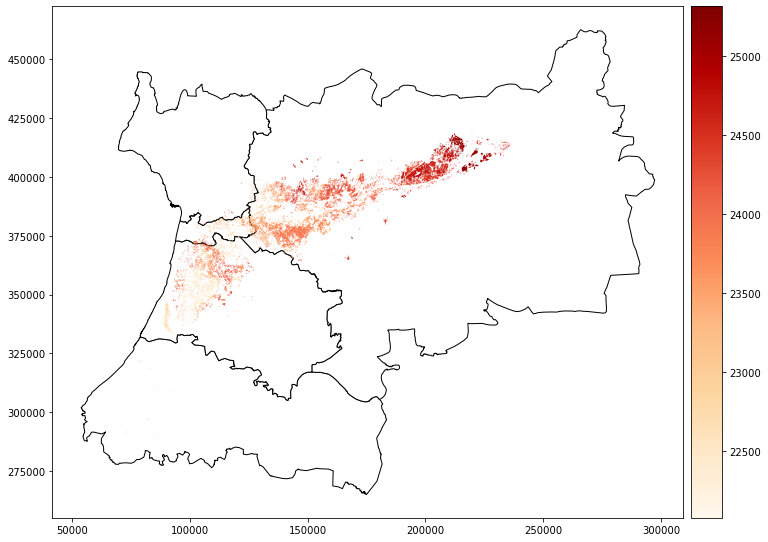

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
df.plot(column='_srad7', ax=ax, cmap='OrRd', legend=True, cax=cax)

In [162]:
df = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\builtup_2013_processed_20200218_clean.csv", encoding='utf-8')
df.drop(columns=['WKT', 'fid', 'DN'], inplace=True)

In [163]:
for column in list(df)[0:-2]:
    df[column] = df[column].astype('float')

In [164]:
df.crs = f'EPSG:{MerchidSudMoroc}'

In [165]:
print(df.shape, df.area_m2.min(), df.area_m2.max(), df.area_m2.mean(), df.area_m2.sum())

(36447, 27) 1.9073486328125e-06 50935410.562068895 11886.569999948315 433229816.7881162


In [167]:
df = df.loc[df.area_m2>=1000]

In [168]:
df = gpd.clip(df, provinces, keep_geom_type=True)

C:\Users\camilorg\AppData\Local\Continuum\anaconda3\envs\geoenv\lib\site-packages\geopandas\geoseries.py:358: UserWarning:

GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)



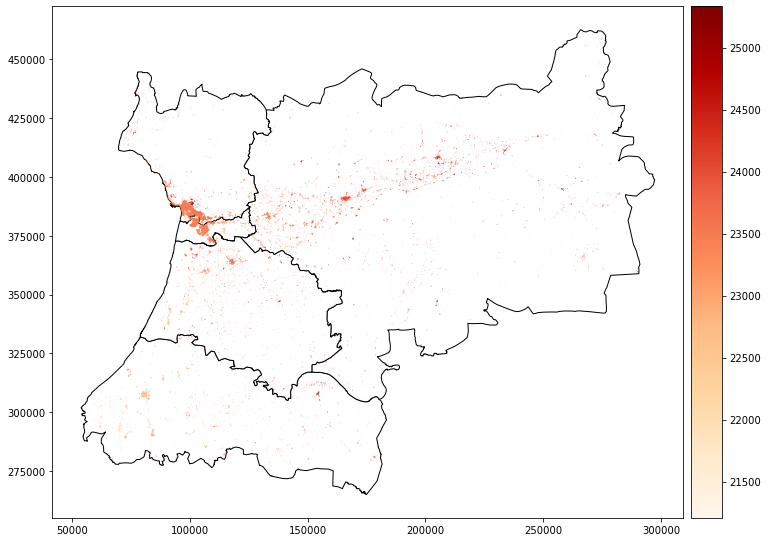

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
df.plot(column='_srad7', ax=ax, cmap='OrRd', legend=True, cax=cax)